In [125]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, InputLayer, \
    Flatten, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report
from tensorflow.image import rgb_to_grayscale, resize
import tempfile

In [78]:
def prepare_data(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    
    # ds = ds.map(lambda x, y: (rgb_to_grayscale(x), y))
    
#     ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#               num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [79]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [80]:
data_augmentation = tf.keras.Sequential([
layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
layers.experimental.preprocessing.RandomRotation(0.2),
layers.experimental.preprocessing.RandomHeight(0.1),
layers.experimental.preprocessing.RandomWidth(0.1),
layers.experimental.preprocessing.RandomZoom(0.1),
])

In [81]:
metadata = pd.read_csv('data/Chest_xray_Corona_Metadata.csv').drop('Unnamed: 0', axis=1)
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [82]:
metadata['Label'].value_counts()

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64

In [83]:
image_root_path = 'data/'

In [84]:
batch_size = 50
input_shape = (256, 256, 3)
AUTOTUNE = tf.data.AUTOTUNE

In [85]:
train_data = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    batch_size=batch_size,
    image_size=input_shape[:2],
    seed=1,
    validation_split=0.2,
    subset='training'
)

Found 5286 files belonging to 2 classes.
Using 4229 files for training.


In [86]:
validation_data = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    batch_size=batch_size,
    image_size=input_shape[:2],
    seed=1,
    validation_split=0.2,
    subset='validation'
)

Found 5286 files belonging to 2 classes.
Using 1057 files for validation.


In [87]:
test_data = image_dataset_from_directory(
    'data/test/',
    labels='inferred',
    image_size=input_shape[:2]
)

Found 624 files belonging to 2 classes.


In [88]:
train_data_pf = prepare_data(train_data, shuffle=True, augment=True)
validation_data_pf = prepare_data(validation_data)
test_data_pf = prepare_data(test_data)

In [158]:
neg, pos = np.bincount(metadata['Label'].map({'Normal': 0, 'Pnemonia': 1}))
total = neg + pos
initial_bias = np.log([pos/neg])
neg, pos, initial_bias

(1576, 4334, array([1.01160091]))

In [159]:
pos/total

0.7333333333333333

In [165]:
def create_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    tf.random.set_seed(0)
    model = Sequential([
        Conv2D(32, 3),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        BatchNormalization(),
        Conv2D(64, 5),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        BatchNormalization(),
        Conv2D(128, 9),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=tf.keras.metrics.BinaryAccuracy()
    )
    
    return model

In [180]:
model = create_model()
model.evaluate(train_data_pf)

85/85 [==============================] - 34s 211ms/step - loss: 31.5582 - binary_accuracy: 0.2549s - loss: 31.6837 - binary_accuracy


[31.55821418762207, 0.2549065947532654]

In [167]:
# Is it better with bias?
model = create_model(output_bias=initial_bias)
model.evaluate(train_data_pf)

85/85 [==============================] - 34s 213ms/step - loss: 30.5027 - binary_accuracy: 0.2549


[30.502704620361328, 0.2549065947532654]

In [161]:
# checkpoint the model weights to make comparison equal between the biased and unbiased models
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [162]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [168]:
# Train a model with output bias

model = create_model(output_bias=initial_bias)
model.load_weights(initial_weights)
biased_history = model.fit(
    train_data_pf,
    batch_size=batch_size,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=validation_data_pf,
    verbose=1
)

Epoch 1/10
85/85 [==============================] - 54s 438ms/step - loss: 0.3593 - binary_accuracy: 0.8392 - val_loss: 0.5577 - val_binary_accuracy: 0.7739
Epoch 2/10
85/85 [==============================] - 51s 422ms/step - loss: 0.3307 - binary_accuracy: 0.8494 - val_loss: 4.2502 - val_binary_accuracy: 0.2498
Epoch 3/10
85/85 [==============================] - 49s 397ms/step - loss: 0.3225 - binary_accuracy: 0.8534 - val_loss: 0.9756 - val_binary_accuracy: 0.5478


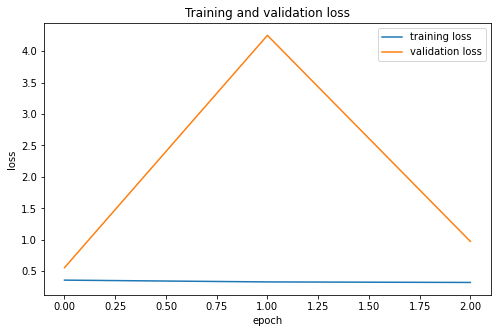

In [171]:
plt.figure(figsize=(8,5))
plt.plot(unbiased_history.history['loss'])
plt.plot(unbiased_history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.show()

In [172]:
model.evaluate(test_data_pf)

20/20 [==============================] - 2s 77ms/step - loss: 1.0991 - binary_accuracy: 0.6362


[1.099084734916687, 0.6362179517745972]

In [173]:
# calculate class weights
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.87
Weight for class 1: 0.68


In [175]:
# Train a model with output bias and class weights

model = create_model(output_bias=initial_bias)
model.load_weights(initial_weights)
biased_history = model.fit(
    train_data_pf,
    batch_size=batch_size,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=validation_data_pf,
    verbose=1,
    class_weight=class_weight
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
85/85 [==============================] - 52s 411ms/step - loss: 0.4174 - binary_accuracy: 0.8342 - val_loss: 2.0025 - val_binary_accuracy: 0.3595
Epoch 2/10
85/85 [==============================] - 49s 391ms/step - loss: 0.3694 - binary_accuracy: 0.8510 - val_loss: 0.4650 - val_binary_accuracy: 0.8023
Epoch 3/10
85/85 [==============================] - 49s 401ms/step - loss: 0.3591 - binary_accuracy: 0.8520 - val_loss: 2.3853 - val_binary_accuracy: 0.3491
Epoch 4/10
85/85 [==============================] - 50s 403ms/step - loss: 0.3574 - binary_accuracy: 0.8579 - val_loss: 2.7455 - val_binary_accuracy: 0.3595


In [176]:
model.evaluate(test_data_pf)

20/20 [==============================] - 2s 80ms/step - loss: 0.5730 - binary_accuracy: 0.7564


[0.5729649662971497, 0.7564102411270142]

In [178]:
y_proba = model.predict(test_data_pf)
y_proba

array([[1.24294674e-02],
       [8.45340252e-01],
       [9.42889214e-01],
       [3.38290751e-01],
       [9.49496746e-01],
       [8.28630507e-01],
       [1.69277471e-02],
       [9.94022667e-01],
       [9.91531551e-01],
       [4.46244851e-02],
       [9.83881831e-01],
       [6.52000844e-01],
       [7.38728940e-02],
       [9.03228879e-01],
       [9.78162587e-01],
       [9.85630989e-01],
       [4.61799681e-01],
       [9.83049810e-01],
       [2.34468356e-01],
       [9.51158464e-01],
       [1.52398814e-02],
       [1.72050640e-01],
       [7.07292020e-01],
       [1.93111468e-02],
       [5.07841408e-01],
       [5.17419875e-01],
       [4.94170576e-01],
       [8.64012182e-01],
       [9.47129428e-01],
       [6.33466244e-02],
       [1.75001144e-01],
       [2.19526961e-01],
       [9.89277482e-01],
       [9.74520385e-01],
       [9.57609236e-01],
       [1.09463595e-01],
       [1.67715121e-02],
       [6.68376312e-02],
       [3.30850869e-01],
       [5.93123317e-01],


In [179]:
y_pred = np.where(y_proba >= 0.5, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.39      0.45      0.42       234
         1.0       0.64      0.58      0.61       390

    accuracy                           0.53       624
   macro avg       0.51      0.52      0.51       624
weighted avg       0.55      0.53      0.54       624



In [18]:
from tensorflow.keras.utils import plot_model

In [19]:
plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
